In [8]:
using Graphs
using LinearAlgebra
using Combinatorics
using SparseArrays
using Plots
using LaTeXStrings
# using GraphPlot
# using Compose

struct HubbardSubspace
    N_up
    N_down
    N::Int
    lattice::AbstractGraph

    function HubbardSubspace(N_up, N_down, lattice::AbstractGraph)
        N = -1
        new(N_up, N_down, N, lattice)
    end
    function HubbardSubspace(N::Int, lattice::AbstractGraph)
        new(-1, -1, N, lattice)
    end
end

function get_subspace_info(hs::HubbardSubspace)
    if hs.N == -1
        return (hs.N_up, hs.N_down)
    end
    return hs.N
end

struct HubbardModel
    t::Float64
    U::Float64
    μ::Float64
    half_filling::Bool
end
function _combination_indexer!(a::Vector{T}, b::T, c::T, idx::Int, comb_dict, inv_comb_dict) where T
    for comb1 in combinations(a, b)
        set1 = Set(comb1)
        for comb2 in combinations(a, c)
            set2 = Set(comb2)
            pair = (set1, set2)
            comb_dict[pair] = idx
            push!(inv_comb_dict, pair)
            idx += 1
        end
    end
    return idx
end
struct CombinationIndexer{T}
    # Given a vector of labels a (typically these would correspond to site numberings),
    # this object associates each permutation of spin up and spin down dirac fermions
    # with an index. comb_dict maps a permutation to an index, and inv_comb_dict maps
    # indices to the permutation.
    a::Vector{T}
    comb_dict::Dict{Tuple{Set{T}, Set{T}}, Int}
    inv_comb_dict::Vector{Tuple{Set{T}, Set{T}}}

   
    function CombinationIndexer(a::Vector{T}, N) where T
        # Constructor for a fock space of exactly N fermions. Goes from N_up=0 N_down=N to N_up=N N_down=0
        comb_dict = Dict{Tuple{Set{T}, Set{T}}, Int}()
        inv_comb_dict = Vector{Tuple{Set{T}, Set{T}}}()
        
        # Generate combinations and populate comb_dict and inv_comb_dict directly
        idx = 1
        for b_val=0:N
            c_val = N - b_val
            idx = _combination_indexer!(a, b_val, c_val, idx, comb_dict, inv_comb_dict)
        end
        
        new{T}(a, comb_dict, inv_comb_dict)
    end
    function CombinationIndexer(a::Vector{T}, b, c) where T
        # Constructor for a fock space with b spin up fermions and c spin down fermions. b and c can be iterables,
        # and if they are, the fock space includes the cartesian product of these iterables.
        comb_dict = Dict{Tuple{Set{T}, Set{T}}, Int}()
        inv_comb_dict = Vector{Tuple{Set{T}, Set{T}}}()
        
        # Generate combinations and populate comb_dict and inv_comb_dict directly
        idx = 1
        for b_val in b
            for c_val in c
                idx = _combination_indexer!(a, b_val, c_val, idx, comb_dict, inv_comb_dict)
            end
        end
        
        new{T}(a, comb_dict, inv_comb_dict)
    end
end

function index(self::CombinationIndexer, comb1::Set, comb2::Set)
    return self.comb_dict[(comb1, comb2)]  # Use tuple as key
end

function combination(self::CombinationIndexer, idx::Int)
    return self.inv_comb_dict[idx]
end

# combination(CombinationIndexer(collect(1:7), 0:3, 0:3), 10)
# Test
# ci = CombinationIndexer(collect(1:9), 2, 2)
# index(ci, Set([1, 2]), Set([2, 1]))

combination (generic function with 1 method)

In [ ]:
function count_in_range(s::Set{T}, a::T, b::T; lower_eq::Bool=true, upper_eq::Bool=true) where T
    ### given a set of numbers s, counts the number of elements that are between
    ### a and b (where a could be larger or less than b). lower_eq and upper_eq specify
    ### whether the upper/lower bound is an equality or an inequality
    count = 0
    upper_bound = maximum([a,b]) 
    lower_bound = minimum([a,b])
    for elem in s
        if lower_eq
            cond1 = lower_bound <= elem
        else
            cond1 = lower_bound < elem
        end 
        if upper_eq
            cond2 = elem <= upper_bound
        else
            cond2 = elem < upper_bound
        end 
        if cond1 && cond2
            count += 1
        end
    end
    return count
end
function create_cicj(Hs::HubbardSubspace)
    # c^dagger_i c_j 

    dim = get_subspace_dimension(Hs)
    indexer = CombinationIndexer(collect(1:nv(Hs.lattice)), get_subspace_info(Hs)...)
    cicj = [spzeros(Float64, dim, dim) for _ in 1:length(indexer.a), _ in 1:length(indexer.a), _ in 1:2]
    for (i1, conf1) in enumerate(indexer.inv_comb_dict)
        for σ ∈ [1, 2]
            for site_index1 ∈ conf1[σ]
                for site_index2 ∈ [setdiff(indexer.a, conf1[σ]); site_index1]
                    new_conf = copy(conf1[σ])
                    delete!(new_conf, site_index1)
                    push!(new_conf, site_index2)
                    if σ == 1
                        i2 = index(indexer, new_conf, conf1[2])
                    else
                        i2 = index(indexer, conf1[1], new_conf)
                    end
                    # sign from jordan-wigner string. assuming i<j, c+_i c_j gives a positive sign times (-1)^(# electrons between sites i and j)
                    # if j < i, then there's an extra negative sign
                    sign = (-1)^(count_in_range(conf1[1], site_index1, site_index2; lower_eq=true, upper_eq=false) + 
                        count_in_range(if (σ == 2) new_conf else conf1[2] end, site_index1, site_index2; lower_eq=false, upper_eq=true) +
                        (site_index1 > site_index2))
                    cicj[site_index1, site_index2, σ][i1, i2] += sign
                end
            end
        end
    end
    return cicj
end
function create_Sx!(rows::Vector{Int}, cols::Vector{Int}, vals::Vector{Float64}, magnitude::Float64, indexer::CombinationIndexer)
    for (i1, conf) in enumerate(indexer.inv_comb_dict) 
        for σ ∈ [1, 2]
            for site_index ∈ setdiff(conf[σ], conf[3-σ])
                if σ == 1
                    i2 = index(indexer, setdiff(conf[1], site_index), union(conf[2], site_index))
                else
                    i2 = index(indexer, union(conf[1], site_index), setdiff(conf[2], site_index))
                end
                push!(rows, i1)
                push!(cols, i2)
                push!(vals, magnitude)
            end
        end
    end
end
function create_SziSzj!(rows::Vector{Int}, cols::Vector{Int}, vals::Vector{Float64}, magnitude::Float64, indexer::CombinationIndexer; iequalsj::Bool=false, NN::Union{Missing, AbstractGraph}=missing)
    if iequalsj
        create_chemical_potential!(rows, cols, vals, 1/4*magnitude, indexer)
        create_hubbard_interaction!(rows, cols, vals, -1/2*magnitude, false, indexer)
    end
    # this is for i != j
    # (n_{i,up} - n_{i,down}) (n_{j,up} - n_{j,down})
    for (i, conf) in enumerate(indexer.inv_comb_dict)
        total = 0
        for σ ∈ [1, 2]
            for σp ∈ [1, 2]
                for site_index1 ∈ setdiff(conf[σ], conf[3-σ])
                    for site_index2 ∈ setdiff(conf[σp], conf[3-σp])
                        if (site_index1 != site_index2) && (ismissing(NN) || (site_index2 in neighbors(NN, site_index1)))
                            total += (-1)^(σ != σp)
                        end
                    end
                end
            end
        end
        push!(rows, i)
        push!(cols, i)
        push!(vals, total/4*magnitude)
    end
end
function create_SiSj!(rows::Vector{Int}, cols::Vector{Int}, vals::Vector{Float64}, magnitude::Float64, indexer::CombinationIndexer; NN::Union{Missing,AbstractGraph}=missing)
    # This is for i!=j
    # c+_{i,up}c_{i,down}c+_{j,down}c_{j,up}
    for (i1, conf) in enumerate(indexer.inv_comb_dict)
        for σ ∈ [1, 2]
            for site_index1 ∈ setdiff(conf[σ], conf[3-σ])
                for site_index2 ∈ setdiff(conf[3-σ], conf[σ])
                    if !ismissing(NN) && !(site_index2 in neighbors(NN, site_index1))
                        continue
                    end
                    if σ == 1
                        i2 = index(indexer, replace(conf[1], site_index1=>site_index2), replace(conf[2], site_index2=>site_index1))
                    else
                        i2 = index(indexer, replace(conf[1], site_index2=>site_index1), replace(conf[2], site_index1=>site_index2))
                    end
                    push!(rows, i1)
                    push!(cols, i2)
                    push!(vals, magnitude/2)
                end
            end
        end
    end
    create_SziSzj!(rows, cols, vals, magnitude, indexer; iequalsj=false, NN=NN)
end
function create_S2!(rows::Vector{Int}, cols::Vector{Int}, vals::Vector{Float64}, magnitude::Float64, indexer::CombinationIndexer)
    # sum Si*Si
    create_chemical_potential!(rows, cols, vals, 3/4*magnitude, indexer)
    create_hubbard_interaction!(rows, cols, vals, -3/2*magnitude, false, indexer)
    create_SiSj!(rows, cols, vals, magnitude, indexer)

end
function create_nn_hopping!(rows::Vector{Int}, cols::Vector{Int}, vals::Vector{Float64}, t::Float64, lattice::AbstractGraph, indexer::CombinationIndexer)
    for (i1, conf1) in enumerate(indexer.inv_comb_dict)
        # if length(intersect(conf1[1], conf1[2])) > 0 
        #     continue
        # end
        for σ ∈ [1, 2]
            for site_index1 ∈ conf1[σ]
                for site_index2 ∈ neighbors(lattice, site_index1)
                    if site_index2 ∉ conf1[σ]
                        new_conf = copy(conf1[σ])
                        delete!(new_conf, site_index1)
                        push!(new_conf, site_index2)
                        # if length(intersect(new_conf, conf1[3-σ])) > 0 
                        #     continue
                        # end
                        if σ == 1
                            i2 = index(indexer, new_conf, conf1[2])
                        else
                            i2 = index(indexer, conf1[1], new_conf)
                        end
                        # evaluating this sign is likely the source of any error
                        # sign from jordan-wigner string. assuming i<j, c+_i c_j gives a positive sign times (-1)^(# electrons between sites i and j)
                        # if j < i, then there's an extra negative sign
                        # sign = (-1)^count_in_range(new_conf, site_index1, site_index2)
                        sign = (-1)^(count_in_range(conf1[1], site_index1, site_index2; lower_eq=true, upper_eq=false) + 
                                    count_in_range(if (σ == 2) new_conf else conf1[2] end, site_index1, site_index2; lower_eq=false, upper_eq=true) +
                                    (site_index1 > site_index2))
                        # println(sign)
                        push!(rows, i1)
                        push!(cols, i2)
                        push!(vals, -t*sign)
                    end
                end
            end
        end
    end
end

function create_hubbard_interaction!(rows::Vector{Int}, cols::Vector{Int}, vals::Vector{Float64}, U::Float64, half_filling::Bool, indexer::CombinationIndexer)
    if half_filling
        for (i, conf) in enumerate(indexer.inv_comb_dict)
            total_U = 0
            num_negative = length(setdiff(union(conf[1], conf[2]), intersect(conf[1], conf[2])))
            num_positive = length(indexer.a) - num_negative
            push!(rows, i)
            push!(cols, i)
            push!(vals, U*(num_positive - num_negative)/4)
        end
    else
        for (i, conf) in enumerate(indexer.inv_comb_dict)
            push!(rows, i)
            push!(cols, i)
            push!(vals, U*length(intersect(conf[1], conf[2])))
        end
    end
end
function create_chemical_potential!(rows::Vector{Int}, cols::Vector{Int}, vals::Vector{Float64}, μ::Float64, indexer::CombinationIndexer)
    for (i, conf) in enumerate(indexer.inv_comb_dict)
        push!(rows, i)
        push!(cols, i)
        # last part breaks degeneracy ensuring that ED orders them consistently
        push!(vals, μ*(length(conf[1]) + length(conf[2])) ) #+ 1e-7*sum(conf[1]) + 43e-7*sum(conf[2]) 
    end
end
function create_Sz!(rows::Vector{Int}, cols::Vector{Int}, vals::Vector{Float64}, magnitude::Float64, indexer::CombinationIndexer)
    for (i, conf) in enumerate(indexer.inv_comb_dict)
        push!(rows, i)
        push!(cols, i)
        push!(vals, magnitude*(length(conf[1]) - length(conf[2])) )
    end
end


function create_Hubbard(Hm::HubbardModel, Hs::HubbardSubspace; perturbations::Bool=false)
    # specify the subspace
    dim = get_subspace_dimension(Hs)
    indexer = CombinationIndexer(collect(1:nv(Hs.lattice)), get_subspace_info(Hs)...)

    rows = Int[]
    cols = Int[]
    vals = Float64[]

    #Constructs the sparse hopping Hamiltonian matrix \sum_{<i,j>} c^\dagger_i c_j.
    create_nn_hopping!(rows, cols, vals, Hm.t, Hs.lattice, indexer)
    create_hubbard_interaction!(rows, cols, vals, Hm.U, Hm.half_filling, indexer)
    create_chemical_potential!(rows, cols, vals, Hm.μ, indexer)
    if perturbations
        create_Sz!(rows, cols, vals, 0.1, indexer)
        create_S2!(rows, cols, vals, 0.13, indexer)
    end
    # create_SziSzj!(rows, cols, vals, 0.021, indexer; iequalsj=true)
    # create_operator!(rows, cols, vals, 1e-2, indexer)

    # constuct Hamiltonian
    H = sparse(rows, cols, vals, dim, dim)
    
    return H
end


function create_Heisenberg(t,J, Hs::HubbardSubspace)
    # specify the subspace
    dim = get_subspace_dimension(Hs)
    indexer = CombinationIndexer(collect(1:nv(Hs.lattice)), get_subspace_info(Hs)...)

    rows = Int[]
    cols = Int[]
    vals = Float64[]

    #Constructs the sparse hopping Hamiltonian matrix \sum_{<i,j>} c^\dagger_i c_j.
    create_nn_hopping!(rows, cols, vals, t, Hs.lattice, indexer)
    create_SiSj!(rows, cols, vals, J, indexer; NN=Hs.lattice)

    # constuct Hamiltonian
    H = sparse(rows, cols, vals, dim, dim)
    
    return H, indexer
end

function get_subspace_dimension(Hs::HubbardSubspace)
    L = nv(Hs.lattice)
    if Hs.N == -1
        total = 0 
        for n_up in Hs.N_up
            for n_down in Hs.N_down
                total += binomial(L,n_up) * binomial(L,n_down)
            end
        end
        return total
    end
    total = 0
    for n_up in 0:Hs.N
        n_down = Hs.N - n_up
            total += binomial(L,n_up) * binomial(L,n_down)
        end
    return total
end

function index(CI::CombinationIndexer, comb::Vector)
    return CI.comb_dict[Set(comb)]
end

function combination(CI::CombinationIndexer, idx::Int)
    return CI.inv_comb_dict[idx]
end




combination (generic function with 1 method)

In [3]:
# using KrylovKit

t = 1
U = 8
μ = 0 # positive incentivises fewer particles (one electron costs this much energy)
# N_up = 2
# N_down = 2
N = 3
half_filling = false
lattice = Graphs.grid((2,3))
# lattice = Graphs.cycle_graph(3)

model = HubbardModel(t,U,μ,half_filling)
subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)
H = create_Hubbard(model, subspace)

E, V = eigen(Matrix(H))
# eigsolve(H, 2, :SR)

# E[2] - E[1]
# jldsave(raw"D:\datasets\dqmc_hubbard\ED.jld2"; E=E, V=V,t=t, U=U,mu=μ, half_filling=half_filling, N_up=N_up, N_down=N_down, lattice=lattice)
# Int.(Matrix(H))

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
220-element Vector{Float64}:
 -4.259638127440806
 -4.059638127440806
 -3.651394110388735
 -3.64092712474619
 -3.544886532449995
 -3.4513941103887356
 -3.4409271247461906
 -3.3448865324499946
 -3.2409271247461904
 -3.1166536112707357
  ⋮
  8.1975
  8.1975
  8.1975
  8.1975
  8.197500000000002
  8.197500000000003
  8.197500000000005
  8.197500000000005
  8.197500000000018
vectors:
220×220 Matrix{Float64}:
 0.0  0.0  0.0   0.176777     0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -0.176777     0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -0.25         0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.25         0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.25         0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -9.12993e-18  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -0.176777     0.0  0.0     0.0  0.0  0.0  0.0  0.

In [19]:
ci = CombinationIndexer(collect(1:nv(lattice)), N_up, N_down)
state_probability = abs.(V[1:end,1]).^2
println(maximum(state_probability))
combination(ci, argmax(state_probability))

0.2905654555379272


(Set([4, 1]), Set([2, 3]))

In [ ]:
using JLD2

jldsave(raw"D:\datasets\dqmc_hubbard\ED.jld2"; E=E, V=U,t=1, U=8,mu=2, half_filling=true, N_up=4, N_down=4, lattice=lattice)

In [4]:
using JLD2

d = load(raw"D:\datasets\dqmc_hubbard\ED.jld2")
V = d["V"]
lattice = d["lattice"]
t = d["t"]
E = d["E"]
μ = d["mu"]
N_up = d["N_up"]
N_down = d["N_down"]

4

# eigenstate comparison

In [4]:
# using KrylovKit

t = 1
U = 8
μ = 0  # positive incentivises fewer particles (one electron costs this much energy)
# N_up = 1:4
# N_down = 1:4
N = 3
half_filling = false
lattice = Graphs.grid((2,3))
# lattice = Graphs.cycle_graph(3)

model = HubbardModel(t,U,μ,half_filling)
subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)
H1 = create_Hubbard(model, subspace)

E1, V1 = eigen(Matrix(H1))
# cicj_array1 = create_cicj(subspace)


Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
220-element Vector{Float64}:
 -4.259638127440806
 -4.059638127440806
 -3.651394110388735
 -3.64092712474619
 -3.544886532449995
 -3.4513941103887356
 -3.4409271247461906
 -3.3448865324499946
 -3.2409271247461904
 -3.1166536112707357
  ⋮
  8.1975
  8.1975
  8.1975
  8.1975
  8.197500000000002
  8.197500000000003
  8.197500000000005
  8.197500000000005
  8.197500000000018
vectors:
220×220 Matrix{Float64}:
 0.0  0.0  0.0   0.176777     0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -0.176777     0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -0.25         0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.25         0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.25         0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -9.12993e-18  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -0.176777     0.0  0.0     0.0  0.0  0.0  0.0  0.

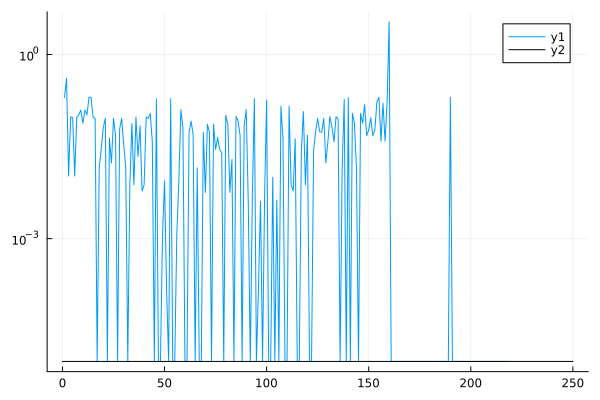

In [9]:
epsilon = 1e-5
plot(diff(real.(E1)).+1e-5, yscale=:log10)
plot!([0,250],[epsilon, epsilon],color="black")
# plot!(diff(E2))

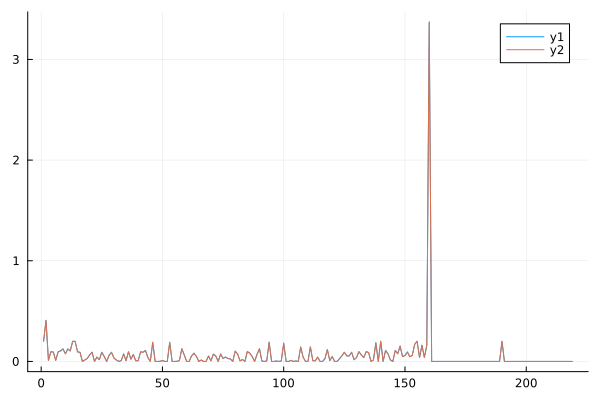

In [13]:
plot(abs.(diff(diag(V1'*H2*V1))))
plot!(abs.(diff(diag(V2'*H2*V2))))

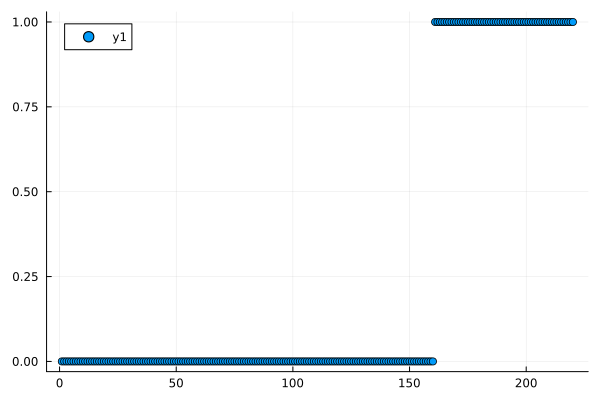

In [19]:
scatter(E1-E2)

In [239]:
sum(abs.(Matrix(H1)*Matrix(H2) - Matrix(H2)*Matrix(H1)))

0.49568868082114736

In [16]:
# using KrylovKit

t = 1
U = 7
μ = 0 # positive incentivises fewer particles (one electron costs this much energy)
# N_up = 1:4
# N_down = 1:4
N = 3
half_filling = false
lattice = Graphs.grid((2,3))
# lattice = Graphs.cycle_graph(3)

model = HubbardModel(t,U,μ,half_filling)
subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)
H2 = create_Hubbard(model, subspace)

E2, V2 = eigen(Matrix(H2))
# cicj_array2 = create_cicj(subspace)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
220-element Vector{Float64}:
 -4.259638127440806
 -4.059638127440807
 -3.6513941103887344
 -3.64092712474619
 -3.5448865324499956
 -3.4513941103887342
 -3.440927124746191
 -3.3448865324499932
 -3.2409271247461904
 -3.116653611270735
  ⋮
  7.197500000000001
  7.197500000000001
  7.197500000000002
  7.197500000000002
  7.197500000000002
  7.1975000000000025
  7.197500000000007
  7.197500000000009
  7.197500000000017
vectors:
220×220 Matrix{Float64}:
 0.0  0.0  0.0   0.176777     0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -0.176777     0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -0.25         0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.25         0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.25         0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -9.12993e-18  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -0.1

In [43]:
U = V1'*V2 # energy basis
# sum(abs.(V1*U - V2))

p = abs.(U).^2
entropy = ifelse.(p .> 0, -p .* log.(p), 0)
# sum(entropy, dims=1)[1:7]
println(sqrt(tr((U-I)*(U-I)')))
sort(collect(Iterators.flatten(sum(entropy, dims=1))))

21.164111439747483


220-element Vector{Real}:
 -1.3322676294594337e-15
 -1.3322675877401919e-15
 -8.881784196489471e-16
 -8.881784152110461e-16
 -8.881783946470448e-16
 -8.881783728964097e-16
 -8.881781775751524e-16
 -4.4408920984410603e-16
 -4.4408920984340616e-16
 -4.440892094559743e-16
 -4.4408920901550995e-16
 -4.4408920843433108e-16
 -4.440892017035139e-16
  ⋮
  2.112446709904766
  2.117842350510945
  2.1233866932571486
  2.131917590078454
  2.1538853908616704
  2.1563823776925948
  2.183380225527846
  2.215692199846435
  2.315467625742235
  2.315467625745109
  2.350202161265325
  2.350202161265331

In [26]:
U = V2*V1' # computational basis 

# this unitary makes more sense to compute the quantum complexity of
p = abs.(U).^2
entropy = ifelse.(p .> 0, -p .* log.(p), 0)
sum(entropy, dims=1)[1:7]

7-element Vector{Float64}:
 4.67502010839971
 4.680287262859502
 4.659354108209212
 4.424107517776376
 4.6178977430646215
 4.729190837543825
 4.55988444900022

In [203]:
sort(diag(U))

56-element Vector{Float64}:
 -0.3622350403989767
 -0.2992150624609179
 -0.28993672285175137
 -0.21152239006569346
 -0.18832856913509408
 -0.1797076847870786
 -0.16965019734967052
 -0.16877421666506393
 -0.14366475399341608
 -0.13935394727038908
  ⋮
  0.10492454137675775
  0.12499828731651998
  0.12499915911691023
  0.2006406396609804
  0.20268272751856967
  0.24772500474752243
  0.3003698974614383
  0.3727207820225861
  0.420179608426703

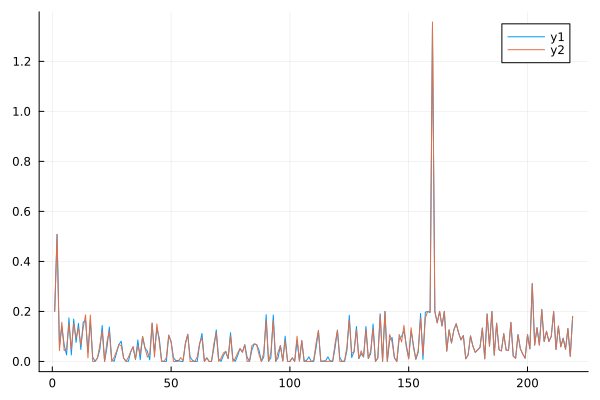

In [58]:
using Plots
plot(diff(E1))
plot!(diff(E2))

In [176]:
cicj = [dot(V2[:,3], cicj_array2[i,j,k]*V2[:,3]) for i=1:4, j=1:4, k=1:2]
for i=1:4
    println(cicj[i,i,1] + cicj[i,i,2])
end

0.749277920394003
0.7507255718773945
0.7507221048571685
0.7492744028714353


# Heisenberg 

In [5]:
N=2
lattice = Graphs.grid((2,2))
# lattice = Graphs.cycle_graph(3)

subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)
h,indexer = create_Heisenberg(1.0, 0.5, subspace)

E,V = eigen(Matrix(h))
println(E)
psi0 = maximum(V[:,1])
for (i, psi) in enumerate(V[:,1])
    if abs.(psi) > 1e-8
        println(psi, " ", combination(indexer, i))
    end
end

[-3.22817805262833, -1.8789024427351722, -1.8789024427351722, -1.8789024427351713, -1.8789024427351713, -1.8789024427351713, -1.8789024427351642, -0.7500000000000022, -0.7499999999999953, -0.7499999999999949, 0.0, 0.0, 5.204170427930421e-17, 5.174920444975781e-16, 2.7555905900771413e-15, 0.25000000000000067, 0.2500000000000009, 0.2500000000000018, 0.2500000000000018, 0.250000000000002, 0.250000000000002, 2.1289024427351744, 2.1289024427351744, 2.128902442735175, 2.128902442735175, 2.128902442735175, 2.1289024427351753, 2.4781780526283317]
-0.2659220264360266 (Set([1]), Set([2]))
-0.2659220264360278 (Set([1]), Set([3]))
0.3295010648121068 (Set([1]), Set([4]))
0.26592202643602886 (Set([2]), Set([1]))
0.3295010648121091 (Set([2]), Set([3]))
-0.26592202643602775 (Set([2]), Set([4]))
0.2659220264360277 (Set([3]), Set([1]))
-0.32950106481210656 (Set([3]), Set([2]))
-0.2659220264360278 (Set([3]), Set([4]))
-0.32950106481210883 (Set([4]), Set([1]))
0.2659220264360276 (Set([4]), Set([2]))
0.265